In [17]:
import pandas as pd
import numpy as np
import joblib 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Fichiers
INPUT_FILE = "train_features_optimized.parquet"
MODEL_FILE = "xgb_final_optimized.pkl"

print("✅ Librairies prêtes.")


✅ Librairies prêtes.


In [18]:
# Chargement
df = pd.read_parquet(INPUT_FILE)

X = df.drop(columns=["userId", "target"])
y = df["target"]

# Split Stratifié (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calcul du déséquilibre (Combien de Non-Churners pour 1 Churner ?)
# Cela va aider le modèle à "peser" ses erreurs.
ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Ratio de déséquilibre : {ratio:.2f}")



Ratio de déséquilibre : 22.06


In [19]:
print("🚀 Entraînement du modèle XGBoost...")

xgb = XGBClassifier(
    n_estimators=600,         # Nombre max d'arbres
    learning_rate=0.03,       # Vitesse (lent = plus précis)
    max_depth=4,              # Profondeur (4 est stable pour éviter l'overfitting)
    scale_pos_weight=ratio,   # GESTION DU DÉSÉQUILIBRE (Très important !)
    eval_metric="auc",        # Métrique interne
    early_stopping_rounds=50, # Arrêt si le score stagne
    random_state=42
)

# Entraînement avec validation en direct
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

print("✅ Entraînement terminé.")


🚀 Entraînement du modèle XGBoost...
[0]	validation_0-auc:0.69729
[100]	validation_0-auc:0.74587
[163]	validation_0-auc:0.74193
✅ Entraînement terminé.


In [20]:
print("🔍 Optimisation du seuil pour le Balanced Accuracy...")

# Prédictions (probabilités) sur la validation
y_proba = xgb.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.01, 1.0, 0.01)
best_score = 0
best_threshold = 0.5

# On teste chaque seuil
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    score = balanced_accuracy_score(y_val, preds)
    
    if score > best_score:
        best_score = score
        best_threshold = t

print(f"\n🏆 RÉSULTAT OPTIMAL :")
print(f"   Meilleur Seuil     : {best_threshold:.2f}")
print(f"   Balanced Accuracy  : {best_score:.4f}")


🔍 Optimisation du seuil pour le Balanced Accuracy...

🏆 RÉSULTAT OPTIMAL :
   Meilleur Seuil     : 0.43
   Balanced Accuracy  : 0.6934


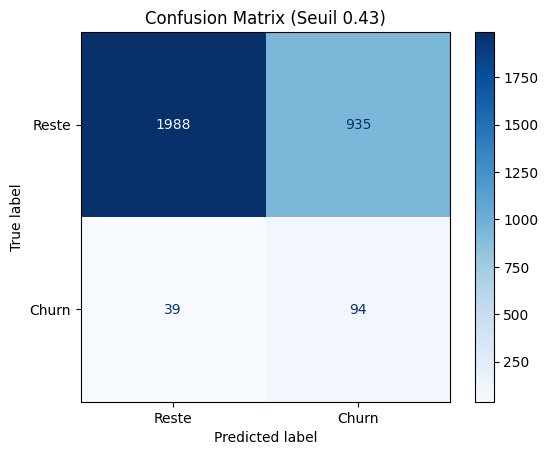

🔝 Top 10 des features les plus importantes :


,feature,importance
7,Thumbs Down,0.248400
1,n_sessions,0.056652
8,Roll Advert,0.053038
11,Downgrade,0.051953
13,satisfaction_ratio,0.050067
18,is_mobile,0.045704
3,recency_days,0.045280
6,Thumbs Up,0.041795
14,trend_listening,0.039260
5,avg_daily_listen,0.038611


In [21]:
# Matrice de confusion avec le meilleur seuil
final_preds = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reste", "Churn"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Seuil {best_threshold})")
plt.show()

# Importance des variables
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("🔝 Top 10 des features les plus importantes :")
display(importances.head(10))


In [22]:
to_save = {
    "model": xgb,
    "threshold": best_threshold
}
joblib.dump(to_save, MODEL_FILE)
print(f"✅ Modèle sauvegardé dans {MODEL_FILE}")

✅ Modèle sauvegardé dans xgb_final_optimized.pkl
